# **Notebook Setup**

**Import Libraries**

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
import pathlib
import shutil
import tempfile

from  IPython import display
from matplotlib import pyplot as plt
from google.colab import drive

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
from scipy.interpolate import interp1d
import numpy as np
from scipy.ndimage.interpolation import rotate, shift
from PIL import Image

print("Tensorflow version is: ", tf.__version__)
assert tf.__version__[0] == '2'

Tensorflow version is:  2.6.0


**Setup Plotting Function**

In [2]:
from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 1.0], title="None"):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    
    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_Val')

  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.title(title)
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

# **Mount Colab to GDrive**

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!cp /content/drive/MyDrive/COSC2779_Deep_Learning/'Assignment 01'/A1_data.zip .

In [5]:
!unzip -q -o A1_data.zip

In [6]:
!unzip -q -o Images.zip

In [7]:
!rm -r Images.zip A1_data.zip __MACOSX

# **Import CSV**

In [8]:
from sklearn.model_selection import train_test_split
train_csv = pd.read_csv("S40AR_train_data.csv")
test_csv = pd.read_csv("S40AR_test_data.csv")
train_data, val_test_data = train_test_split(train_csv, test_size=0.2, shuffle=True,random_state=0)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, shuffle=True,random_state=0)

In [ ]:
print("Train length",len(train_data))
print("Test length",len(test_data))
print("Validation length",len(val_data))

Train length 2424
Test length 303
Validation length 303


In [ ]:
train_data.head(2)

,FileName,action,action_class
2551,Img_8254.jpg,texting_message,using_comm_device
175,Img_1511.jpg,feeding_a_horse,Interacting_with_animal


In [ ]:
val_data.head(2)

,FileName,action,action_class
2789,Img_8928.jpg,texting_message,using_comm_device
2246,Img_7388.jpg,riding_a_horse,Interacting_with_animal


In [ ]:
test_data.head(2)

,FileName,action,action_class
628,Img_2822.jpg,taking_photos,using_comm_device
983,Img_3820.jpg,taking_photos,using_comm_device


In [ ]:
actions = train_csv['action'].unique().tolist()
for action in actions:
  train_data['action'].replace(to_replace=action, value=int(actions.index(action)), inplace=True)
  val_data['action'].replace(to_replace=action, value=int(actions.index(action)), inplace=True)

action_classes = train_csv['action_class'].unique().tolist()
for action_class in action_classes:
  train_data['action_class'].replace(to_replace=action_class, value=int(action_classes.index(action_class)), inplace=True)
  val_data['action_class'].replace(to_replace=action_class, value=int(action_classes.index(action_class)), inplace=True)  

In [ ]:
train_data.head(2)

,FileName,action,action_class
2551,Img_8254.jpg,9,3
175,Img_1511.jpg,11,0


In [ ]:
val_data.head(2)

,FileName,action,action_class
2789,Img_8928.jpg,9,3
2246,Img_7388.jpg,14,0


In [ ]:
test_data.head(2)

,FileName,action,action_class
628,Img_2822.jpg,taking_photos,using_comm_device
983,Img_3820.jpg,taking_photos,using_comm_device


# **Data Exploration**

In [ ]:
import PIL
img = PIL.Image.open("/content/Images/Img_1.jpg")
img.format

'JPEG'

In [ ]:
img.getbands

<bound method Image.getbands of <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x451 at 0x7F1F54830E90>>

In [ ]:
np.asarray(img).shape

(451, 300, 3)

In [ ]:

img1 = PIL.Image.open("/content/Images/Img_1.jpg")
img1.size

(300, 451)

In [ ]:
img2 = PIL.Image.open("/content/Images/Img_1294.jpg")
img2.size

(402, 300)

In [ ]:
img3 = PIL.Image.open("/content/Images/Img_1158.jpg")
img3.size

(801, 600)

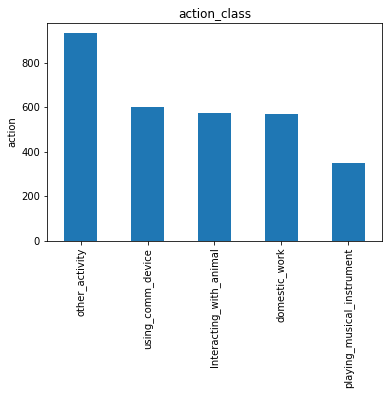

In [ ]:
freq = train_csv['action_class'].value_counts()
plt.xticks(rotation=45)
plt.ylabel('action')
plt.title('action_class')
freq.plot(kind='bar')

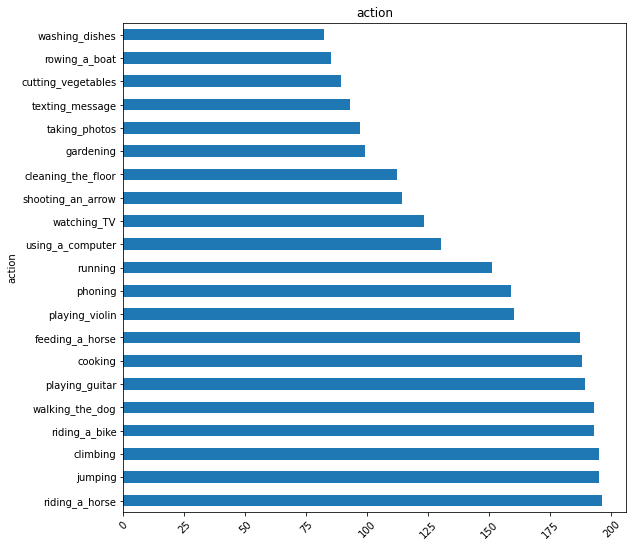

In [ ]:
freq = train_csv['action'].value_counts()
plt.figure(figsize=(9,9))
plt.xticks(rotation=45)
plt.ylabel('action')
plt.title('action')
freq.plot(kind='barh')

# **Data Loader**

In [10]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_frame, batch_size=8, dim=(224, 224, 3), n_classes=21, data_mean=0, data_std=1,  data_prefix='', shuffle=True, Augment=True):
        'Initialization'
        
        self.dim = dim  
        self.batch_size = batch_size
        self.n_classes = n_classes  
        
        self.shuffle = shuffle  
        self.Augment = Augment 

        
        self.data_frame = data_frame
        self.image_label = data_frame['action'].values.tolist()
        self.image_label2 = data_frame['action_class'].values.tolist()
        self.image_ids = np.arange(len(self.image_label)).tolist()
        self.data_prefix = data_prefix
        
       
        self.data_mean = data_mean
        self.data_std = data_std
        
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data for the given index'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        

        
        data_ids_temp = [self.image_ids[k] for k in indexes]
        image_label_temp = [self.image_label[k] for k in indexes]
        image_label2_temp = [self.image_label2[k] for k in indexes]        
        

       
        X, y, y2 = self.__data_generation(data_ids_temp, image_label_temp, image_label2_temp)
        

        return X, [y, y2]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            

    def __data_generation(self, data_ids_temp, image_label_temp, image_label2_temp):
        'Generates data containing batch_size samples' 
               
        X = np.empty((self.batch_size, *self.dim)) # 64, 224, 224, 3
        y = np.empty((self.batch_size), dtype=int) # single array
        y2 = np.empty((self.batch_size), dtype=int) # single array
        

        
        for i, ids in enumerate(data_ids_temp):
            X[i,] = self.__read_data_instance(data_ids_temp[i])
            y[i] = image_label_temp[i]
            y2[i] = image_label2_temp[i]
            
        

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes), keras.utils.to_categorical(y2, num_classes=5)


    def __read_data_instance(self, pid):
      filepath = self.data_prefix + self.data_frame.iloc[pid]['FileName']
      
      data = Image.open(filepath)
      data = data.resize((224,224))
      data = np.asarray(data)
      


      if self.Augment:
          rot = np.random.rand(1) < 0.5
          if rot:
              rot = np.random.randint(-10,10, size=1)
              data = rotate(data, angle=rot[0], reshape=False)
          
          shift_val = np.random.randint(-5, high=5, size=2, dtype=int).tolist() + [0,]
          data = shift(data, shift_val, order=0, mode='constant', cval=0.0, prefilter=False)

      X = data
      X = (X - self.data_mean)/self.data_std
      return X

# **BaseLine Model(VGG16) + Dense Layer**

In [11]:
!pip install Keras-Applications

     |████████████████████████████████| 50 kB 2.7 MB/s 


In [12]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers
from keras.applications.vgg16 import VGG16
from tensorflow.keras import initializers

def get_model(regularizer=None, dropout=None, action_act='sigmoid', action_class_act='sigmoid'):
  Image_size = [224, 224]

  if dropout == None:
    print("Dropout not selected")
    vgg = VGG16(input_shape=Image_size+[3], weights='imagenet', include_top=False)
    for layer in vgg.layers:
      layer.trainable = False

    flat1 = Flatten()(vgg.output)
    flat2 = Flatten()(vgg.output)
    if regularizer == None:
      print("regularizer not selected")
      layer1 = Dense(100, activation=action_act, bias_initializer=initializers.Zeros())(flat1)
      layer2 = Dense(50, activation=action_class_act, bias_initializer=initializers.Zeros())(flat2)
    else:
      print("regularizer selected")
      layer1 = Dense(100, activation=action_act, kernel_regularizer=regularizer, bias_initializer=initializers.Zeros())(flat1)
      layer2 = Dense(50, activation=action_class_act, kernel_regularizer=regularizer, bias_initializer=initializers.Zeros())(flat2)

    pred_action = Dense(21, activation='softmax', name="action", bias_initializer=initializers.Zeros())(layer1)
    pred_class = Dense(5, activation='softmax', name="action_class", bias_initializer=initializers.Zeros())(layer2)
  else:
    print("Dropout selected")
    vgg = VGG16(input_shape=Image_size+[3], weights='imagenet', include_top=False)
    for layer in vgg.layers:
      layer.trainable = False

    flat1 = Flatten()(vgg.output)
    flat2 = Flatten()(vgg.output)
    if regularizer == None:
      print("regularizer not selected")
      layer1 = Dense(100, activation=action_act, bias_initializer=initializers.Zeros())(flat1)
      tf.keras.layers.Dropout(dropout)
      layer2 = Dense(50, activation=action_class_act, bias_initializer=initializers.Zeros())(flat2)
    else:
      print("regularizer selected")
      layer1 = Dense(100, activation=action_act, kernel_regularizer=regularizer, bias_initializer=initializers.Zeros())(flat1)
      tf.keras.layers.Dropout(dropout)
      layer2 = Dense(50, activation=action_class_act, kernel_regularizer=regularizer, bias_initializer=initializers.Zeros())(flat2)

    pred_action = Dense(21, activation='softmax', name="action", bias_initializer=initializers.Zeros())(layer1)
    pred_class = Dense(5, activation='softmax', name="action_class", bias_initializer=initializers.Zeros())(layer2)


  model = Model(inputs=vgg.input, outputs=[pred_action, pred_class])
  return model

baseline_model = get_model()
baseline_model.summary()

Dropout not selected
58900480/58889256 [==============================] - 1s 0us/step
regularizer not selected
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0

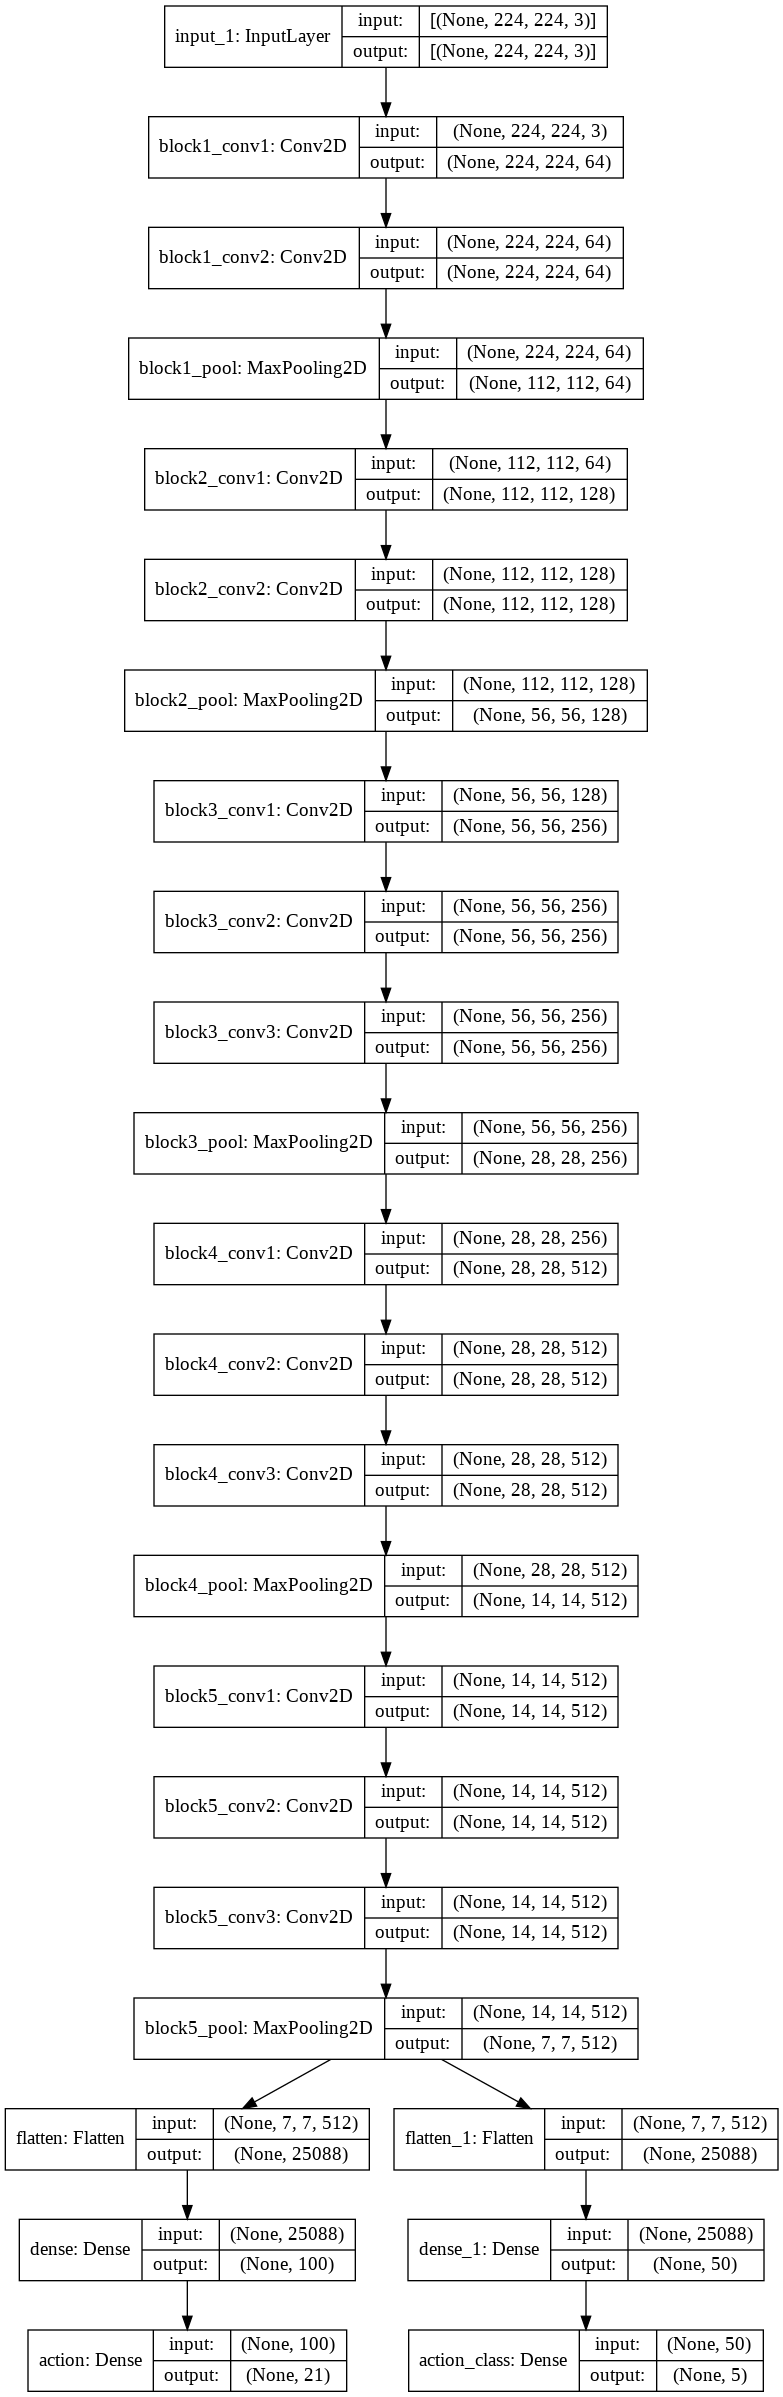

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(baseline_model, to_file='model_graph.png', show_shapes=True)

### **Training with BaseLine Model**

In [13]:
BATCH_SIZE = 64
data_mean = 0.
data_std = 255.0
prefix='/content/Images/'
training_generator = DataGenerator(train_data, batch_size=BATCH_SIZE, data_mean=data_mean, data_std=data_std, n_classes=21, Augment=False, data_prefix=prefix)
validation_generator = DataGenerator(val_data, batch_size=BATCH_SIZE, data_mean=data_mean, data_std=data_std, n_classes=21, Augment=False, data_prefix=prefix)


37
(64, 224, 224, 3) [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0

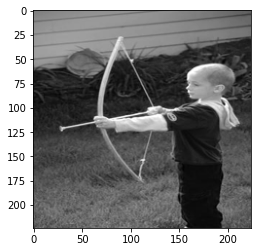

(64, 224, 224, 3) [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],

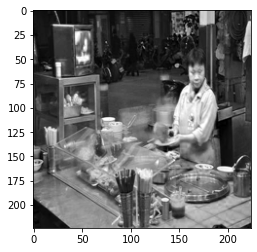

(64, 224, 224, 3) [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],

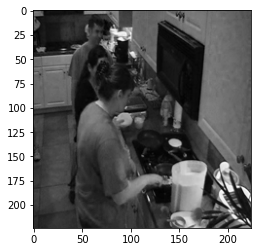

(64, 224, 224, 3) [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],

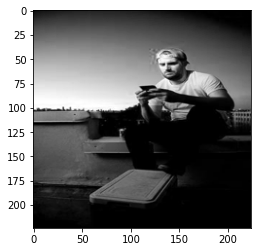

(64, 224, 224, 3) [array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],

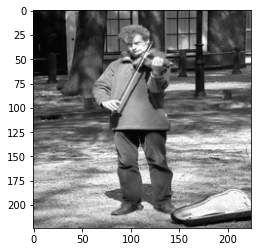

KeyboardInterrupt: ignored

In [ ]:
# check to make sure the training data is generated. After few iterations I have stopped it once I get to know its working properly. Thus there is Keyboard interruption error.

print(training_generator.__len__())

for i,j in training_generator.__iter__():
  print(i.shape, j)
  # plt.imshow(i[0,:,:,0])
  plt.imshow(i[0,:,:,0], cmap='gray')
  plt.pause(.1)

In [15]:
def compile_fit(model, optimizer=tf.keras.optimizers.Adam(), callbacks=None, epochs=10):
  losses = {'action': 'categorical_crossentropy',
            'action_class': 'categorical_crossentropy'
          }
  metrics = {'action': 'accuracy',
            'action_class': 'accuracy'    
          }
  model.compile(optimizer = tf.keras.optimizers.Adam(),
                loss=losses,
                metrics=metrics
              )
  return model.fit(training_generator, epochs=epochs, validation_data=validation_generator, verbose=1, callbacks=callbacks, )

In [ ]:
m_histories = {}
m_histories['baseline_model'] = compile_fit(baseline_model, optimizer=tf.keras.optimizers.Adam(), epochs=10)

### **Plots for BaseLine model**

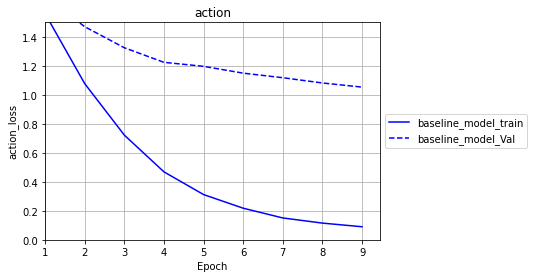

In [ ]:
plotter(m_histories, ylim=[0.0, 1.5], metric = 'action_loss', title="action")

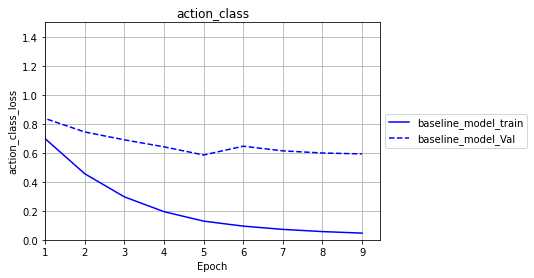

In [ ]:
plotter(m_histories, ylim=[0.0, 1.5], metric = 'action_class_loss', title="action_class")

### **Evaluation on test data(Without Augmentation)**

In [ ]:
test = test_data
for action in actions:
  test['action'].replace(to_replace=action, value=int(actions.index(action)), inplace=True)
for action_class in action_classes:
  test['action_class'].replace(to_replace=action_class, value=int(action_classes.index(action_class)), inplace=True)  
result = DataGenerator(test, batch_size=BATCH_SIZE, data_mean=data_mean, data_std=data_std, n_classes=21, Augment=False, data_prefix=prefix)
r = baseline_model.evaluate(result)

In [ ]:
print("action accuracy = ",r[3])
print("action_class accuracy = ",r[4])

action accuracy =  0.640625
action_class accuracy =  0.7890625


# **Tuning BaseLine Model**

### **Setting Early Callbacks**

In [16]:
def get_callbacks():
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8),
  ]

### **Augmentation of data**

In [17]:
BATCH_SIZE = 64
data_mean = 0.
data_std = 255.0
prefix='/content/Images/'
training_generator = DataGenerator(train_data, batch_size=BATCH_SIZE, data_mean=data_mean, data_std=data_std, n_classes=21, Augment=True, data_prefix=prefix)
validation_generator = DataGenerator(val_data, batch_size=BATCH_SIZE, data_mean=data_mean, data_std=data_std, n_classes=21, Augment=False, data_prefix=prefix)

In [ ]:
aug_model = get_model()
m_histories = {}
m_histories['Augmented'] = compile_fit(aug_model, callbacks=get_callbacks(), epochs=20)

Dropout not selected
regularizer not selected
Epoch 1/20
37/37 [==============================] - 59s 2s/step - loss: 3.9937 - action_loss: 2.7710 - action_class_loss: 1.2228 - action_accuracy: 0.2462 - action_class_accuracy: 0.5519 - val_loss: 3.3557 - val_action_loss: 2.3699 - val_action_class_loss: 0.9858 - val_action_accuracy: 0.3984 - val_action_class_accuracy: 0.6953
Epoch 2/20
37/37 [==============================] - 57s 2s/step - loss: 2.9425 - action_loss: 2.1328 - action_class_loss: 0.8096 - action_accuracy: 0.5224 - action_class_accuracy: 0.7635 - val_loss: 2.8933 - val_action_loss: 2.0880 - val_action_class_loss: 0.8053 - val_action_accuracy: 0.5742 - val_action_class_accuracy: 0.7461
Epoch 3/20
37/37 [==============================] - 58s 2s/step - loss: 2.3941 - action_loss: 1.7904 - action_class_loss: 0.6037 - action_accuracy: 0.6888 - action_class_accuracy: 0.8594 - val_loss: 2.7198 - val_action_loss: 1.8991 - val_action_class_loss: 0.8207 - val_action_accuracy: 0.6133 

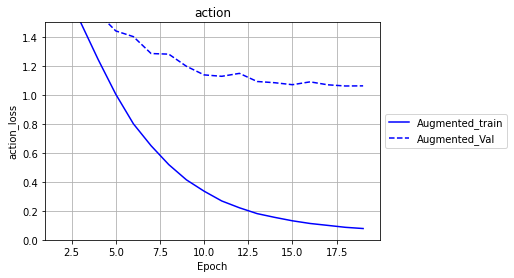

In [ ]:
plotter(m_histories, ylim=[0.0, 1.5], metric = 'action_loss', title="action")

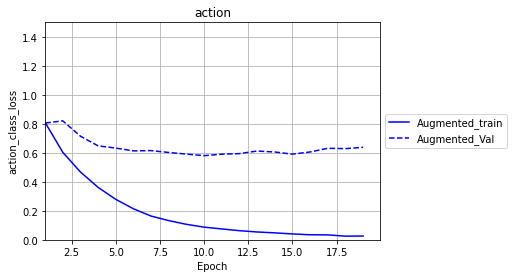

In [ ]:
plotter(m_histories, ylim=[0.0, 1.5], metric = 'action_class_loss', title="action")

### **Select Activation**

In [ ]:
m_histories = {}

model1 = get_model(action_act='sigmoid', action_class_act='sigmoid')
m_histories['sigmoid'] = compile_fit(model1, optimizer=tf.keras.optimizers.Adam(), epochs=8)
model2 = get_model(action_act='relu', action_class_act='relu')
m_histories['relu'] = compile_fit(model2, optimizer=tf.keras.optimizers.Adam(), epochs=8)
model3 = get_model(action_act='elu', action_class_act='elu')
m_histories['elu'] = compile_fit(model3, optimizer=tf.keras.optimizers.Adam(), epochs=8)
model4 = get_model(action_act='leaky_relu', action_class_act='leaky_relu')
m_histories['leaky_relu'] = compile_fit(model4, optimizer=tf.keras.optimizers.Adam(), epochs=8)

Dropout not selected
regularizer not selected
Epoch 1/8
37/37 [==============================] - 59s 2s/step - loss: 4.2692 - action_loss: 2.8332 - action_class_loss: 1.4360 - action_accuracy: 0.2365 - action_class_accuracy: 0.4362 - val_loss: 3.7882 - val_action_loss: 2.6022 - val_action_class_loss: 1.1860 - val_action_accuracy: 0.2461 - val_action_class_accuracy: 0.5781
Epoch 2/8
37/37 [==============================] - 57s 2s/step - loss: 3.4133 - action_loss: 2.3704 - action_class_loss: 1.0429 - action_accuracy: 0.4552 - action_class_accuracy: 0.6841 - val_loss: 3.4108 - val_action_loss: 2.3697 - val_action_class_loss: 1.0411 - val_action_accuracy: 0.4258 - val_action_class_accuracy: 0.6953
Epoch 3/8
37/37 [==============================] - 57s 2s/step - loss: 2.9713 - action_loss: 2.1010 - action_class_loss: 0.8704 - action_accuracy: 0.6119 - action_class_accuracy: 0.8062 - val_loss: 3.1258 - val_action_loss: 2.1913 - val_action_class_loss: 0.9344 - val_action_accuracy: 0.5312 - v

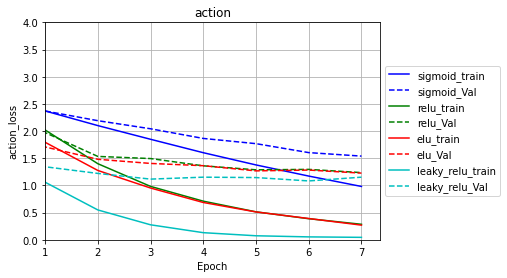

In [ ]:
plotter(m_histories, ylim=[0.0, 4], metric = 'action_loss', title="action")

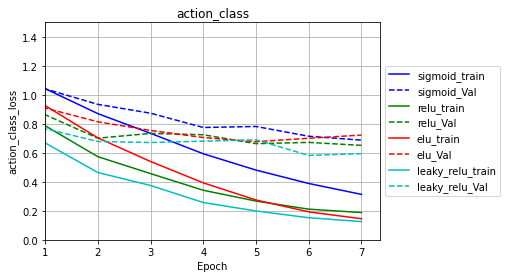

In [ ]:
plotter(m_histories, ylim=[0.0, 1.5], metric = 'action_class_loss', title="action_class")

### **Regularization**

In [ ]:
regularizer_l2 = tf.keras.regularizers.l2(0.001)
model3 = get_model(regularizer=regularizer_l2, action_act='elu', action_class_act='leaky_relu')
regularizer_l1 = tf.keras.regularizers.l1(0.001)
model4 = get_model(regularizer=regularizer_l1, action_act='elu', action_class_act='leaky_relu')
m_histories = {}
m_histories['L2_regularizer'] = compile_fit(model3, callbacks=get_callbacks(), epochs=8)
m_histories['L1_regularizer'] = compile_fit(model4, callbacks=get_callbacks(), epochs=8)

Dropout not selected
regularizer selected
Dropout not selected
regularizer selected
Epoch 1/8
37/37 [==============================] - 58s 2s/step - loss: 6.4567 - action_loss: 3.5710 - action_class_loss: 2.5804 - action_accuracy: 0.1660 - action_class_accuracy: 0.4464 - val_loss: 3.6271 - val_action_loss: 2.3318 - val_action_class_loss: 0.9873 - val_action_accuracy: 0.2773 - val_action_class_accuracy: 0.6016
Epoch 2/8
37/37 [==============================] - 57s 2s/step - loss: 2.8897 - action_loss: 1.9198 - action_class_loss: 0.6713 - action_accuracy: 0.4489 - action_class_accuracy: 0.7724 - val_loss: 2.8562 - val_action_loss: 1.7896 - val_action_class_loss: 0.7766 - val_action_accuracy: 0.5000 - val_action_class_accuracy: 0.7031
Epoch 3/8
37/37 [==============================] - 57s 2s/step - loss: 2.1482 - action_loss: 1.3631 - action_class_loss: 0.4970 - action_accuracy: 0.6402 - action_class_accuracy: 0.8514 - val_loss: 2.5001 - val_action_loss: 1.5043 - val_action_class_loss: 0.

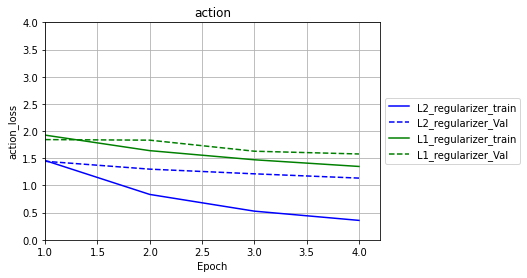

In [ ]:
plotter(m_histories, ylim=[0.0, 4], metric = 'action_loss', title="action")

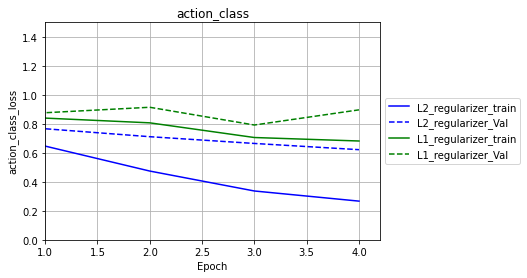

In [ ]:
plotter(m_histories, ylim=[0.0, 1.5], metric = 'action_class_loss', title="action_class")

### **Dropout**

In [18]:
dropout = 0.3
model4 = get_model(dropout=dropout, action_act='elu', action_class_act='leaky_relu')
dropout = 0.4
model5 = get_model(dropout=dropout, action_act='elu', action_class_act='leaky_relu')
m_histories = {}
m_histories['dropout_0.3'] = compile_fit(model4, callbacks=get_callbacks(), epochs=8)
m_histories['dropout_0.4'] = compile_fit(model5, callbacks=get_callbacks(), epochs=8)

Dropout selected
regularizer not selected
Dropout selected
regularizer not selected
Epoch 1/8
37/37 [==============================] - 60s 2s/step - loss: 5.3044 - action_loss: 3.7252 - action_class_loss: 1.5793 - action_accuracy: 0.1867 - action_class_accuracy: 0.5211 - val_loss: 3.3240 - val_action_loss: 2.4521 - val_action_class_loss: 0.8718 - val_action_accuracy: 0.3125 - val_action_class_accuracy: 0.7031
Epoch 2/8
37/37 [==============================] - 57s 2s/step - loss: 2.5352 - action_loss: 1.9174 - action_class_loss: 0.6178 - action_accuracy: 0.4831 - action_class_accuracy: 0.7876 - val_loss: 2.5644 - val_action_loss: 1.8465 - val_action_class_loss: 0.7180 - val_action_accuracy: 0.4883 - val_action_class_accuracy: 0.7422
Epoch 3/8
37/37 [==============================] - 56s 2s/step - loss: 1.7219 - action_loss: 1.3075 - action_class_loss: 0.4144 - action_accuracy: 0.6677 - action_class_accuracy: 0.8670 - val_loss: 2.1501 - val_action_loss: 1.4965 - val_action_class_loss: 0.

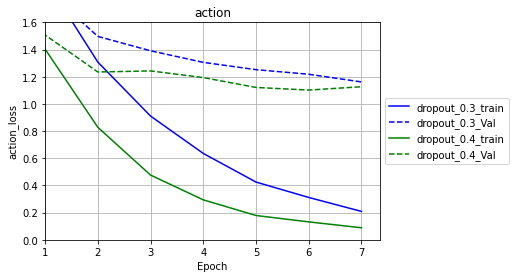

In [19]:
plotter(m_histories, ylim=[0.0, 1.6], metric = 'action_loss', title="action")

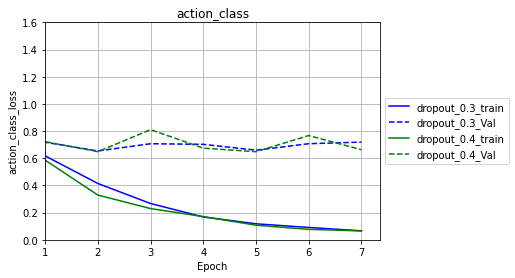

In [20]:
plotter(m_histories, ylim=[0.0, 1.6], metric = 'action_class_loss', title="action_class")

### **Dropout+Regularization**

In [ ]:
regularizer=tf.keras.regularizers.l2(0.001)
dropout=0.3
model6 =get_model(regularizer=regularizer, dropout=dropout, action_act='elu', action_class_act='leaky_relu')
m_histories = {}
m_histories['dropout+regularization'] = compile_fit(model6, callbacks=get_callbacks(), epochs=8)

Dropout selected
regularizer selected
Epoch 1/8
37/37 [==============================] - 59s 2s/step - loss: 5.7848 - action_loss: 3.4303 - action_class_loss: 2.0458 - action_accuracy: 0.2563 - action_class_accuracy: 0.4911 - val_loss: 3.2340 - val_action_loss: 1.9850 - val_action_class_loss: 0.9339 - val_action_accuracy: 0.4766 - val_action_class_accuracy: 0.6367
Epoch 2/8
37/37 [==============================] - 56s 2s/step - loss: 2.4908 - action_loss: 1.4640 - action_class_loss: 0.7169 - action_accuracy: 0.6014 - action_class_accuracy: 0.7487 - val_loss: 2.4849 - val_action_loss: 1.4382 - val_action_class_loss: 0.7405 - val_action_accuracy: 0.5938 - val_action_class_accuracy: 0.7500
Epoch 3/8
37/37 [==============================] - 58s 2s/step - loss: 1.7061 - action_loss: 0.8874 - action_class_loss: 0.5123 - action_accuracy: 0.7728 - action_class_accuracy: 0.8514 - val_loss: 2.3238 - val_action_loss: 1.3120 - val_action_class_loss: 0.7043 - val_action_accuracy: 0.6211 - val_actio

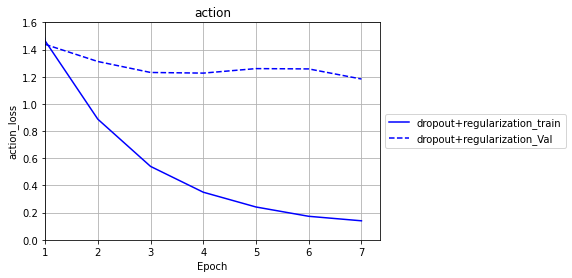

In [ ]:
plotter(m_histories, ylim=[0.0, 1.6], metric = 'action_loss', title="action")

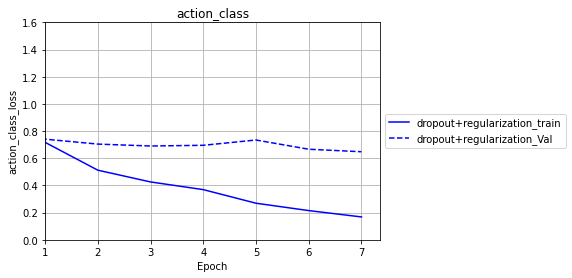

In [ ]:
plotter(m_histories, ylim=[0.0, 1.6], metric = 'action_class_loss', title="action_class")

### **Selecting Optimizer**

In [ ]:
STEPS_PER_EPOCH = len(train_data)//BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

optimizer=tf.keras.optimizers.Adam(lr_schedule)
tf.keras.backend.clear_session()
model7 = get_model(regularizer=tf.keras.regularizers.l2(0.001), dropout=0.3, action_act='elu', action_class_act='leaky_relu')

optimizer=tf.keras.optimizers.SGD(lr_schedule)
tf.keras.backend.clear_session()
model8 = get_model(regularizer=tf.keras.regularizers.l2(0.001), dropout=0.3, action_act='elu', action_class_act='leaky_relu')

optimizer=tf.keras.optimizers.RMSprop(lr_schedule)
tf.keras.backend.clear_session()
model9 = get_model(regularizer=tf.keras.regularizers.l2(0.001), dropout=0.3, action_act='elu', action_class_act='leaky_relu')

m_histories = {}
m_histories['Adam'] = compile_fit(model7, optimizer=optimizer, callbacks=get_callbacks(), epochs=8)
m_histories['SGD'] = compile_fit(model8, optimizer=optimizer, callbacks=get_callbacks(), epochs=8)
m_histories['RMSprop'] = compile_fit(model9, optimizer=optimizer, callbacks=get_callbacks(), epochs=8)

Dropout selected
regularizer selected
Dropout selected
regularizer selected
Dropout selected
regularizer selected
Epoch 1/8
37/37 [==============================] - 60s 2s/step - loss: 5.7356 - action_loss: 3.4251 - action_class_loss: 2.0046 - action_accuracy: 0.2846 - action_class_accuracy: 0.4802 - val_loss: 3.0769 - val_action_loss: 1.8546 - val_action_class_loss: 0.9106 - val_action_accuracy: 0.4844 - val_action_class_accuracy: 0.6445
Epoch 2/8
37/37 [==============================] - 57s 2s/step - loss: 2.2273 - action_loss: 1.3194 - action_class_loss: 0.6006 - action_accuracy: 0.6427 - action_class_accuracy: 0.7889 - val_loss: 2.5999 - val_action_loss: 1.4272 - val_action_class_loss: 0.8691 - val_action_accuracy: 0.5977 - val_action_class_accuracy: 0.6719
Epoch 3/8
37/37 [==============================] - 58s 2s/step - loss: 1.4922 - action_loss: 0.8227 - action_class_loss: 0.3660 - action_accuracy: 0.7910 - action_class_accuracy: 0.8754 - val_loss: 2.3097 - val_action_loss: 1.33

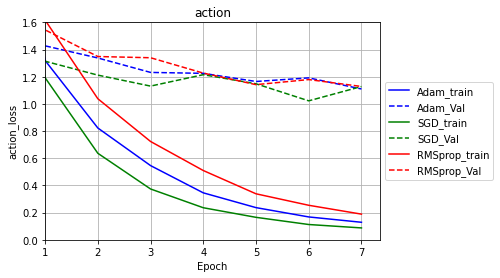

In [ ]:
plotter(m_histories, ylim=[0.0, 1.6], metric = 'action_loss', title="action")

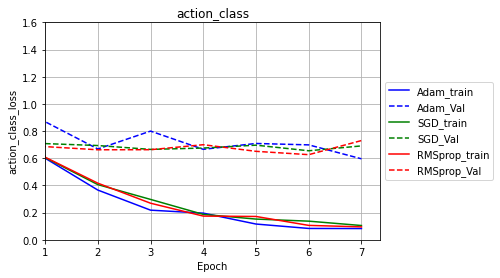

In [ ]:
plotter(m_histories, ylim=[0.0, 1.6], metric = 'action_class_loss', title="action_class")

In [ ]:
model7.save("adam_model.h5")

### **Fine-tuning top layers**

In [ ]:
tuned_model = tf.keras.models.load_model("adam_model.h5")

In [ ]:
def get_callbacks():
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
  ]

tuned_model.trainable = True

print("Number of layers in the base model: ", len(tuned_model.layers))

fine_tune_at = 23

# Freeze all the layers before the `fine_tune_at` layer
for layer in tuned_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  25


In [ ]:
m_histories = {}
m_histories['tuned_model'] = compile_fit(tuned_model, optimizer=tf.keras.optimizers.Adam(lr_schedule), callbacks=get_callbacks(), epochs=25)

Epoch 1/25
37/37 [==============================] - 59s 2s/step - loss: 0.4136 - action_loss: 0.0825 - action_class_loss: 0.0500 - action_accuracy: 0.9970 - action_class_accuracy: 0.9958 - val_loss: 2.0070 - val_action_loss: 1.0939 - val_action_class_loss: 0.6321 - val_action_accuracy: 0.6953 - val_action_class_accuracy: 0.7930
Epoch 2/25
37/37 [==============================] - 58s 2s/step - loss: 0.3903 - action_loss: 0.0691 - action_class_loss: 0.0401 - action_accuracy: 0.9970 - action_class_accuracy: 0.9996 - val_loss: 2.0607 - val_action_loss: 1.1275 - val_action_class_loss: 0.6522 - val_action_accuracy: 0.6836 - val_action_class_accuracy: 0.7891
Epoch 3/25
37/37 [==============================] - 57s 2s/step - loss: 0.3786 - action_loss: 0.0600 - action_class_loss: 0.0375 - action_accuracy: 0.9970 - action_class_accuracy: 0.9975 - val_loss: 2.2407 - val_action_loss: 1.2220 - val_action_class_loss: 0.7377 - val_action_accuracy: 0.6680 - val_action_class_accuracy: 0.7891
Epoch 4/25

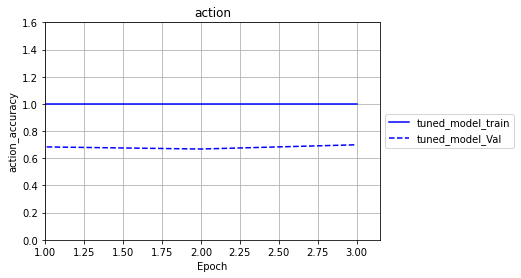

In [ ]:
plotter(m_histories, ylim=[0.0, 1.6], metric = 'action_accuracy', title="action")

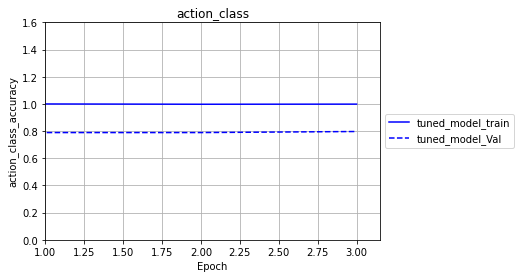

In [ ]:
plotter(m_histories, ylim=[0.0, 1.6], metric = 'action_class_accuracy', title="action_class")

### **Evaluation on Test Data(with tuned model)**

In [ ]:
test = test_data
for action in actions:
  test['action'].replace(to_replace=action, value=int(actions.index(action)), inplace=True)
for action_class in action_classes:
  test['action_class'].replace(to_replace=action_class, value=int(action_classes.index(action_class)), inplace=True)  
result = DataGenerator(test, batch_size=BATCH_SIZE, data_mean=data_mean, data_std=data_std, n_classes=21, Augment=False, data_prefix=prefix)
r = tuned_model.evaluate(result)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


4/4 [==============================] - 3s 594ms/step - loss: 2.0321 - action_loss: 1.1152 - action_class_loss: 0.6359 - action_accuracy: 0.6562 - action_class_accuracy: 0.7852


In [ ]:
print("action accuracy = ",r[3])
print("action_class accuracy = ",r[4])

action accuracy =  0.65625
action_class accuracy =  0.78515625


# **Prediction on unseen test Data and creating CSV file**

In [ ]:
l = len(test_csv)
test_mat = np.empty((l, *(224, 224, 3)))
img_list = list()
i = 0
for url in test_csv['FileName']:
  img = PIL.Image.open('/content/Images/'+url)
  img_list.append(url)
  img = img.resize((224,224))
  if len(np.asarray(img).shape) == 3:
    test_mat[i,] = np.asarray(img)
    i = i+1
  else:
    test_mat[i,] = np.expand_dims(np.asarray(img),2)
    i = i+1


In [ ]:
output = tuned_model.predict(test_mat/255)

In [ ]:
s = len(output[0])
df = list()
for i in range(s):
  d = {'FileName':img_list[i],
       'action':actions[np.argmax(output[0][i])],
       'action_class':action_classes[np.argmax(output[1][i])]
       }
  df.append(d)  
  # print(actions[np.argmax(output[0][i])]," --- ", action_classes[np.argmax(output[1][i])])

df1 = pd.DataFrame(df, columns =['FileName', 'action', 'action_class'])

In [ ]:
df1.to_csv('s3789918_predictions.csv', index=False, encoding='utf-8')